<a href="https://colab.research.google.com/github/kexinz8/fashionMNIST/blob/main/stat542_proj_no_preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score

from sklearn import metrics

# Import data

In [3]:
train = pd.read_csv("C:\\Users\\asus\\Downloads\\archive (4)\\fashion-mnist_train.csv")
test = pd.read_csv("C:\\Users\\asus\\Downloads\\archive (4)\\fashion-mnist_test.csv")

In [4]:
train_labels = train.loc[:,"label"]
train_x = train.iloc[:,1:]
test_labels = test.loc[:,"label"]
test_x = test.iloc[:,1:]

# Multiclassification
## LightGBM

In [5]:
from lightgbm import LGBMClassifier

In [6]:
# dont run this part, i'm still tuning
err_list = []
for i in np.arange(0.0, 1.0, 0.1):
    model = LGBMClassifier(objective='multiclass',path_smooth = i)
    model.fit(train_x, train_labels, categorical_feature=[0,3])
    predictions = model.predict(test_x)
    error = sum(predictions!=test_labels)/len(test_labels)
    err_list.append(error)
err_list

C:\Users\asus\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\asus\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\asus\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\asus\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\asus\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\asus\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Us

[0.0939, 0.0947, 0.0945, 0.0936, 0.0943, 0.0927, 0.0952, 0.094, 0.0941, 0.0948]

In [ ]:
lgb_model = LGBMClassifier(objective='multiclass',path_smooth = 0.5)
lgb_model.fit(train_x,train_labels,categorical_feature=[0,3])

In [ ]:
expected_y  = test_labels
predicted_y = lgb_model.predict(test_x)
lightGBM_pred_y = predicted_y
print(metrics.classification_report(expected_y, predicted_y))

In [ ]:
report = metrics.classification_report(expected_y, predicted_y, output_dict=True)
pd.DataFrame(report).transpose()

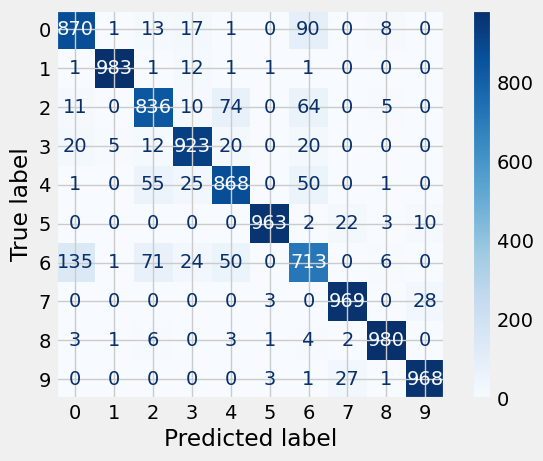

In [292]:
# plot
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(test_labels, lightGBM_pred_y, cmap='Blues')

In [7]:
import matplotlib.pyplot as plt
import numpy as np

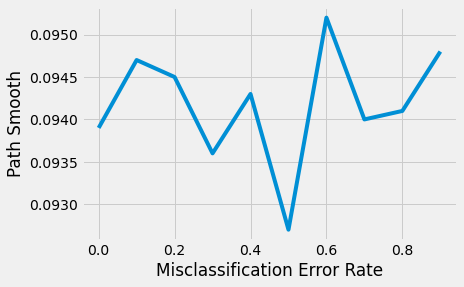

In [8]:
tune = np.arange(0.0, 1.0, 0.1)
error = np.array(err_list)

plt.style.use("fivethirtyeight")
plt.plot(tune, error)

plt.xlabel("Misclassification Error Rate")
plt.ylabel("Path Smooth")

plt.show()

## LDA

In [287]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [288]:
lda = LDA(n_components=9)

In [289]:
expected_y  = test_labels
lda_model = lda.fit(train_x, train_labels)
predicted_y = lda_model.predict(test_x)
lda_pred_y = predicted_y
print(metrics.classification_report(expected_y, predicted_y))

              precision    recall  f1-score   support

           0       0.80      0.77      0.78      1000
           1       0.99      0.94      0.97      1000
           2       0.76      0.71      0.73      1000
           3       0.82      0.87      0.85      1000
           4       0.75      0.79      0.77      1000
           5       0.86      0.89      0.88      1000
           6       0.59      0.60      0.60      1000
           7       0.87      0.85      0.86      1000
           8       0.94      0.92      0.93      1000
           9       0.90      0.91      0.90      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



In [290]:
report = metrics.classification_report(expected_y, predicted_y, output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
0,0.801670,0.7680,0.784474,1000.0000
1,0.994709,0.9400,0.966581,1000.0000
2,0.755814,0.7150,0.734841,1000.0000
3,0.821698,0.8710,0.845631,1000.0000
4,0.746212,0.7880,0.766537,1000.0000
5,0.862403,0.8900,0.875984,1000.0000
6,0.585673,0.6050,0.595180,1000.0000
7,0.871560,0.8550,0.863200,1000.0000
8,0.937564,0.9160,0.926657,1000.0000
9,0.897233,0.9080,0.902584,1000.0000


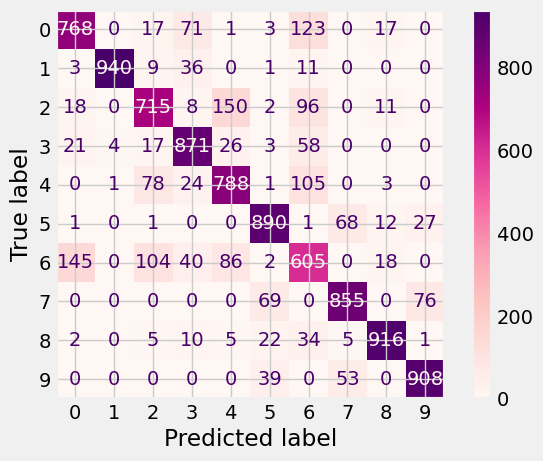

In [291]:
# plot
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(test_labels, lda_pred_y, cmap='RdPu')

## SVM

In [293]:
from sklearn import svm
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [ ]:
# Use Ploynomial kernel 
svmpoly = svm.SVC(kernel='poly', degree=3, C=1).fit(train_x, train_labels)

In [ ]:
expected_y  = test_labels
predicted_y = svmpoly.predict(test_x)
SVM_pred_y = predicted_y
print(metrics.classification_report(expected_y, predicted_y))

In [ ]:
report = metrics.classification_report(expected_y, predicted_y, output_dict=True)
pd.DataFrame(report).transpose()

In [ ]:
# plot
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(test_labels, SVM_pred_y, cmap='RdPu')

Combine the three models results

In [ ]:
# to get the precision dictionary
out = {}
for i in range(0,10):
    out.update({i:round(report[str(i)]['precision'],2)})

In [ ]:
# create df of y_pred of test set for each model
y_pred_test = pd.concat([pd.DataFrame(lightGBM_pred_y, columns = ['LightGBM']),
           pd.DataFrame(lda_pred_y, columns = ['LDA']), 
           pd.DataFrame(SVM_pred_y, columns = ['SVM'])],axis=1)

In [ ]:
y_pred_test.to_csv('y_pred_test.csv')

# Ensemble


In [9]:
import lightgbm as ltg
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import svm
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import StackingClassifier

In [10]:
estimator = []
estimator.append(('LDA', LDA(n_components=9)))
estimator.append(('SVC', svm.SVC(kernel='poly', degree=3, C=1)))
estimator.append(('LGBM', ltg.LGBMClassifier(objective='multiclass',path_smooth = 0.2)))

## Voting

In [7]:
vot_hard=VotingClassifier(estimators = estimator, voting ='hard')
vot_hard.fit(train_x, train_labels)

VotingClassifier(estimators=[('LDA',
                              LinearDiscriminantAnalysis(n_components=9)),
                             ('SVC', SVC(C=1, kernel='poly')),
                             ('LGBM',
                              LGBMClassifier(objective='multiclass',
                                             path_smooth=0.2))])

In [8]:
# predict with voting-ensembled model and check accuracy on testing set
ypred=vot_hard.predict(test_x)
accuracy_score(test_labels, ypred)

0.89

In [10]:
expected_y  = test_labels
predicted_y = ypred
print(metrics.classification_report(expected_y, predicted_y))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1000
           1       0.99      0.98      0.98      1000
           2       0.84      0.81      0.83      1000
           3       0.90      0.91      0.91      1000
           4       0.85      0.84      0.85      1000
           5       0.91      0.95      0.93      1000
           6       0.74      0.71      0.72      1000
           7       0.93      0.92      0.92      1000
           8       0.97      0.96      0.97      1000
           9       0.96      0.94      0.95      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [11]:
report = metrics.classification_report(expected_y, predicted_y, output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
0,0.808511,0.874,0.839981,1000.00
1,0.991870,0.976,0.983871,1000.00
2,0.836588,0.814,0.825139,1000.00
3,0.901381,0.914,0.907646,1000.00
4,0.849246,0.845,0.847118,1000.00
5,0.914505,0.952,0.932876,1000.00
6,0.739267,0.706,0.722251,1000.00
7,0.929878,0.915,0.922379,1000.00
8,0.974645,0.961,0.967774,1000.00
9,0.955420,0.943,0.949170,1000.00


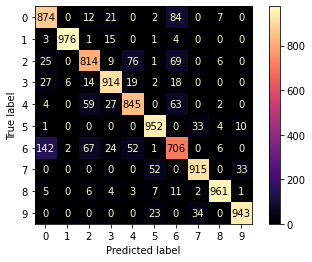

In [9]:
#plot# plot
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(test_labels, ypred, cmap='magma')

## Voting++

In [ ]:
# Construct the reference table
ref1 = {0: 0.84, 1: 1.0, 2: 0.84, 3: 0.91, 4: 0.85, 5: 0.99, 6: 0.75, 7: 0.95, 8: 0.98, 9: 0.96}
ref2 = {0: 0.80, 1: 1.0, 2: 0.76, 3: 0.82, 4: 0.75, 5: 0.86, 6: 0.59, 7: 0.87, 8: 0.94, 9: 0.90}
ref3 = {0: 0.80, 1: 0.99, 2: 0.83, 3: 0.90, 4: 0.85, 5: 0.82, 6: 0.71, 7: 0.92, 8: 0.98, 9: 0.96}
ref_df = [ref1, ref2, ref3]

In [ ]:
ypred_org = y_pred_test
ypred = ypred_org.copy()

In [ ]:
# represent the y_test_pred with according precision
for i in range(ypred.shape[1]):
    ypred.iloc[:,i] = ypred.iloc[:,i].replace(ref_df[i])

ypred.columns = [1,2,3]
ypred

In [ ]:
# For each sample, take the result from model with highest precision 
n=ypred.idxmax(axis='columns')
result=[]
for j in range(len(n)):
    m=n[j]-1
    result.append(ypred_org.iloc[j,m])

In [ ]:
# Calculate the precision for udf model
udf_report=metrics.classification_report(test_labels, result, output_dict=True)
pd.DataFrame(udf_report).transpose()

# Stacking

In [11]:
clf = StackingClassifier(estimators=estimator, final_estimator=LogisticRegression(max_iter=200, solver='liblinear'))
clf.fit(train_x, train_labels).score(test_x, test_labels)

0.9084